In [1]:
import os
import json
import wandb
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = hoomd.device.GPU(gpu_ids=[3])

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40354 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 45515


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [1000]

In [6]:
# Initialize simulation with the appropriate box size 
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density) ** (1/3.)

snapshot = build.get_simulation_box(box_length=L)

In [7]:
# Build random, dense initial conformations
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-1))

In [8]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes)

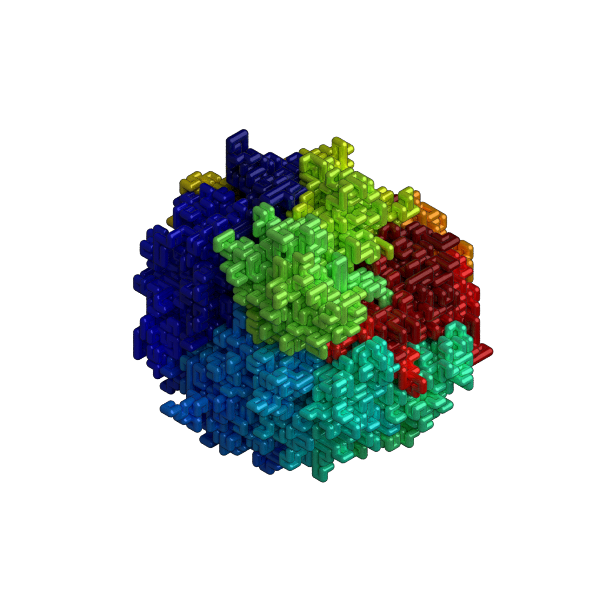

In [9]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, cmap="jet").static(pathtrace=True)

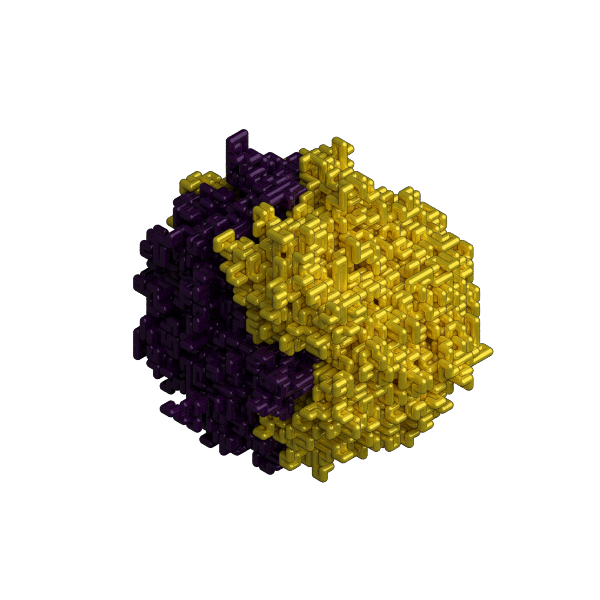

In [10]:
# Render individual chromosomes
render.fresnel(snapshot, show_chromosomes=True).static(pathtrace=True)

In [11]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [12]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [13]:
# Read input force parameters
with open("force_dict_heteropolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "KG"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.1
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 5.0,
                    "B": 5.0
                },
                "B": {
                    "A": 5.0,
                    "B": 5.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [15]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [ ]:
# Set DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)

In [16]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + dpd_forces

In [27]:
# Setup new DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [28]:
logger = log.get_logger(system)

In [ ]:
class RGWriter(hoomd.custom.Action):
    def __init__(self, project_name: str = 'hoomd'):
        self.run = wandb.init(project=project_name)
        self.file = {}

    def act(self, timestep):
        """Write out a new frame to the trajectory."""
        snapshot = self._state.get_snapshot()
        pos = snapshot.particles.position
        rg = Rg2(pos)
        self.file[timestep] = rg
        wandb.log({"timestep": timestep, "Rg": rg})

In [ ]:
# Update simulation engine
system.operations.integrator = dpd_integrator

system.operations.writers.append(log.table_formatter(logger, period=1e4))
system.operations.writers.append(hoomd.write.CustomWriter(action=RGWriter('hoomd'), trigger=100))

In [29]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      210000           6178.13340     0:00:30.753625           1.06578          
      220000           6939.95253     0:00:25.936777           1.03808          
      230000           7234.23373     0:00:23.499379           1.03996          
      240000           7363.55498     0:00:21.728635           1.02385          
      250000           7441.92319     0:00:20.156080           1.02667          
      260000           7502.99718     0:00:18.659210           1.01754          
      270000           7538.32648     0:00:17.245207           1.02297          
      280000           7563.95665     0:00:15.864713           1.04138          
      290000           7580.63719     0:00:14.510654           1.03205          
      300000           7597.52412     0:00:13.162183           1.03437          
      310000           7605.93066     0:00:11.832871           1.03981          
      320000           7610.